In [1]:
import numpy as np
import torch
from torch import Tensor

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from itertools import chain
from healing_mnist import HealingMNIST

/home/use/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/use/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [17]:
mnist = HealingMNIST(digits=[1])

dataset_size = min(len(mnist.train_images), 6000)

X_train = Tensor(mnist.train_images[:dataset_size].reshape(dataset_size, 5, 784).astype(int)).cuda()
U_train = Tensor(np.transpose(np.stack([np.sin((mnist.train_rotations[:dataset_size] / 180.) * np.pi * i) for i in range(25)] + [np.cos((mnist.train_rotations[:dataset_size] / 180.) * np.pi * i) for i in range(25)]), axes=[1, 2, 0])).cuda()

In [78]:
D = 784
dim = D
z_dim = 784

St = torch.zeros((z_dim), requires_grad=True, device='cuda:0')
Sphi = torch.zeros((z_dim), requires_grad=True, device='cuda:0')

Fk = torch.nn.Sequential(
    torch.nn.Linear(z_dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(dim, dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(dim, dim),
    torch.nn.Sigmoid()
).cuda()

Gk1 = torch.nn.GRUCell(50, z_dim).cuda()
Gk2 = torch.nn.GRUCell(50, z_dim).cuda()

Q = torch.nn.Sequential(
    torch.nn.Linear(dim, z_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(z_dim, z_dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(z_dim, z_dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(z_dim, z_dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(z_dim, z_dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(z_dim, z_dim),
    torch.nn.Sigmoid()
).cuda()

In [79]:
from tqdm import tqdm_notebook

T = 5
delta = 1

optimizer = torch.optim.Adam(chain(Gk.parameters(), Fk.parameters(), Q.parameters(), [Sphi, St]), lr=1e-3)
l = []
lp = []
lt = []

for k in tqdm_notebook(range(10000)):
    
    batch_size = 1
    
    batch_x = X_train[(k%(len(X_train) // batch_size))::(len(X_train) // batch_size)] 
    batch_u = U_train[(k%(len(X_train) // batch_size))::(len(X_train) // batch_size)]
    
    sample_size = 1
    
    SphiPos = torch.exp(Sphi)
    StPos = torch.exp(St)

    logp = 0
    logp += (T-1) * D * torch.prod(StPos)
    logp -= T * torch.sum(Sphi)   # sum_t torch.log(torch.prod(Sphi))
    logp += torch.prod(SphiPos)  # trace of diag
    logp += (T - 1) * torch.prod(SphiPos / StPos)  # sum^T_t=2 trace(diag(St)^-1 @ diag(Sphi))
    
    
    mu_q_t = Q(batch_x)
    
    logp += torch.mean(torch.sum((mu_q_t[:, 0, :] * mu_q_t[:, 0, :]), dim=1))
    
    # shape [sample_size, batch_size, 5, 784], random
    sample_z = mu_q_t + (SphiPos * torch.normal(torch.zeros((sample_size, batch_size, 5, z_dim), device='cuda:0'), 
                                                torch.ones((sample_size, batch_size, 5, z_dim), device='cuda:0')))
    # shape [sample_size, batch_size, 5, 784], random
    Gt_tmp = Gk1(batch_u.unsqueeze(0).repeat(sample_size, 1, 1, 1).reshape(sample_size*batch_size*5, -1), 
                 sample_z.reshape(sample_size*batch_size*5, -1))

    Gt_t_2T = Gk2(batch_u.unsqueeze(0).repeat(sample_size, 1, 1, 1).reshape(sample_size*batch_size*5, -1), 
                  Gt_tmp).reshape(sample_size, batch_size, 5, -1)

    # averaging over random sample
    logp += (1./(sample_size * batch_size))*torch.sum(((Gt_t_2T[:, :, :4, :] - mu_q_t[:, 1:, :]) * 
                                                       (Gt_t_2T[:, :, :4, :] - mu_q_t[:, 1:, :]) / StPos))
    logp *= 0.5

    p = Fk(sample_z)
    loss = torch.nn.functional.binary_cross_entropy(input=p.reshape(-1, T*784), 
                                                    target=batch_x.unsqueeze(0).repeat(sample_size, 1, 1, 1).reshape(-1, T*784))
    
    total_loss = loss + logp 
    
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    l.append(loss.data)
    lt.append(total_loss.data)
    lp.append(logp.data)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

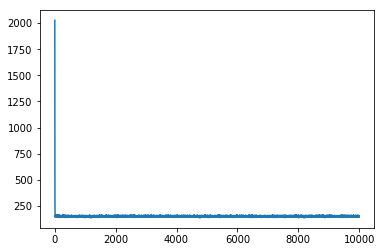

In [80]:
plt.plot(lt)

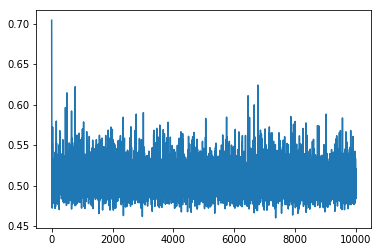

In [81]:
plt.plot(l)

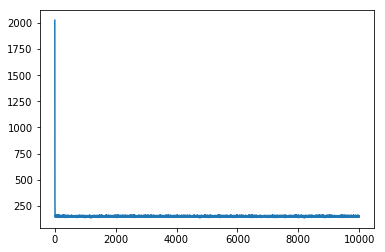

In [82]:
plt.plot(lp)

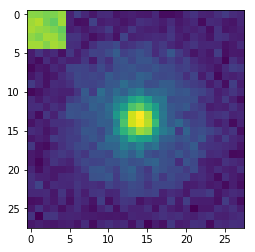

In [83]:
plt.imshow(Fk(Q(X_train[0]))[0].detach().reshape(28, 28))

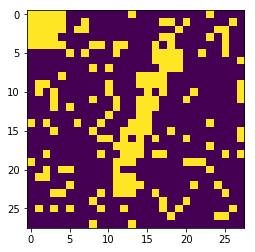

In [74]:
plt.imshow(X_train[0][0].reshape(28, 28))

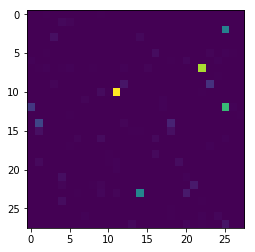

In [84]:
plt.imshow(Q(X_train[2]).detach()[0].reshape(28, 28))

In [ ]:
plt.imshow(Q(X_train[2]).detach()[0].reshape(28, 28))

In [ ]:
X_train[0]

In [99]:
mnist = HealingMNIST()

# dataset_size = min(len(mnist.train_images), 6000)

X_train = Tensor(mnist.train_images.reshape(-1, 5, 784).astype(int)).cuda()

In [100]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(784, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, 50),
).cuda()

decoder = torch.nn.Sequential(
    torch.nn.Linear(50, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, 784),
    torch.nn.Sigmoid(),
).cuda()

In [101]:
from tqdm import tqdm_notebook


optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=1e-3)
l = []
for k in tqdm_notebook(range(10000)):
    
    batch_size = 1
    
    batch_x = X_train[(k%(len(X_train) // batch_size))::(len(X_train) // batch_size)].reshape(-1, 784) 
    
    z = encoder(batch_x)
    restored = decoder(z)
    
    loss = torch.nn.functional.binary_cross_entropy(input=restored, target=batch_x)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    l.append(loss.data)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

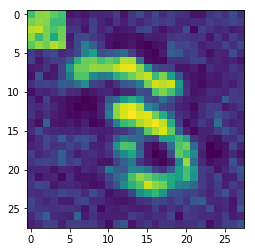

In [109]:
plt.imshow(decoder(encoder(X_train[30][0])).detach().reshape(28, 28))

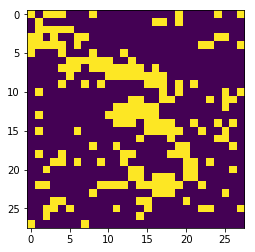

In [110]:
plt.imshow(X_train[30][0].detach().reshape(28, 28))